# 1. Instalación e importación de bibliotecas

In [1]:
!git clone https://github.com/angelfergar/ChurnRetention-SP.git

Cloning into 'ChurnRetention-SP'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 74 (delta 31), reused 26 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 2.68 MiB | 5.09 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorIndexer,VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier as DTSpark
from pyspark.ml.classification import RandomForestClassifier as RFSpark
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [5]:
dataset_path = '/content/ChurnRetention-SP/data/preprocessed_customerChurn.csv'
df = pd.read_csv(dataset_path)

# 2. Equilibrado de datos

Creamos los dataset que usaremos para el entrenamiento de los modelos

In [6]:
df_X = df.drop('Churn Label', axis=1)
df_y = df['Churn Label']

In [7]:
features = df_X.columns.tolist()
label = 'Churn Label'

spark_x = df[features]
spark_y = df[label]

Aumentamos de forma sintética la clase minoritaria un 65% y reduce la clase mayoritaria en un 25% (Se llega a estas cifras a base de prueba y error). De esta forma, pasamos de tener una proporción de 3:1 a una de 1.25 sin introducir un exceso de ruido que pueda provocar overfitting en el modelo ni perder una gran cantidad de datos.

In [8]:
smote = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.8)

# Creamos un pipeline para aplicar ambas técnicas a la vez
pipeline = Pipeline([('smote', smote), ('under', under)])

# Obtenemos dos nuevos datasets con los datos equilibrados
X_resampled, y_resampled = pipeline.fit_resample(spark_x, spark_y)

# Creamos el dataframe que pasaremos a Spark
df_spark = pd.DataFrame(X_resampled, columns=features)
df_spark[label] = y_resampled

# 3. Preparación de Spark

Lo primero que haremos para trabajar con Spark es iniciar una sesión.

In [9]:
spark = SparkSession.builder.appName('ChurnRetention-SP').getOrCreate()

spark_df = spark.createDataFrame(df_spark)

A continuación, transformamos los datos en un formato que sea compatible para Spark. Se necesitan que las columnas estén en una única columna de tipo Vector.

In [10]:
feature_columns = [col for col in df_spark.columns if col != 'Churn Label']
label_column = 'Churn Label'

# Ponemos las features en un solo vector para que puedan ser usadas por modelos de ML de Spark
assembler = VectorAssembler(inputCols=feature_columns, outputCol='rawFeatures')
spark_df = assembler.transform(spark_df)

feature_indexer = VectorIndexer(inputCol='rawFeatures', outputCol='features')
spark_df = feature_indexer.fit(spark_df).transform(spark_df)

# Convertimos la label en índices numéricos para su uso en el modelo de Spark
label_indexer = StringIndexer(inputCol=label_column, outputCol='indexedLabel')
spark_df = label_indexer.fit(spark_df).transform(spark_df)

El último paso previo al entrenamiento de los modelos es obtener los dataFrames de test y train.

In [11]:
train_df, test_df = spark_df.randomSplit([0.7, 0.3])

# 4. Entrenamiento de los modelos

En este apartado vamos a trabajar con tres de los modelos incluídos en la librería de MLlib de Spark: **Decision Tree, Random Forest y GBTClassifier**.

Al ser una introducción al escalado a Spark del proyecto realizado, no entraremos tan en detalle en las métricas como en el notebook de ML estándar. Aún así, es importante mencionar que nos centraremos en la métrica del **F1-Score**, tal como se hizo en el notebook de Model_Training. Esto se debe a que contamos con un dataset desequilibrado, y al haber aplicado técnicas de equilibrado.

También usaremos la **Matriz de Confusión**, **AUC ROC** y **Precision-Recall** para sacar más información sobre cada uno de los modelos, así como la **importancia de las features** a la hora de determinar las clases.

Finalmente, aplicaremos métodos de **fine tuning** propios de Spark para incrementar la efectividad del mejor modelo entrenado.

Crearemos una serie de funciones para poder reutilizar código y mostrar más fácilmente todo el reporte de cada uno de los modelos. El primer paso será entrenar el modelo y mostrar las features que más impactan a la hora de predecir el Churn

In [15]:
# Con esta función entrenamos el modelo y obtenemos predicciones
def train_model(model_type, train_df, test_df):
    model = model_type.fit(train_df)
    pred = model.transform(test_df)
    return model, pred

In [58]:
# Obtenemos la importancia de las diferentes features
def importance_features(model, feature_columns):
    feature_importance = model.featureImportances
    # Coleccionamos las features y las ordenamos
    feature_importance_dict = {feature: importance for feature, importance in zip(feature_columns, feature_importance)}
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Mostramos las 10 features más importantes
    print('Feature más importantes:')
    for feature, importance in sorted_features[:10]:
        print(f'{feature}: {importance:.4f}')

Las siguientes funciones se usarán para mostrar información sobre las métricas. Obtenemos Precision, Recall, F1-Score, y AUC ROC y AUC Precision-Recall

In [40]:
def get_metrics(predictions, label_col='indexedLabel'):
    # Preparamos los evaluadores de cada una de las métricas (Precision, Recall, F1-Score)
    precision_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='precisionByLabel')
    recall_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='recallByLabel')
    f1_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName='f1')

    # En este caso tenemos que dividir precision y recall en dos, ya que se nos dan los valores para ambas clases originalmente
    precision_0 = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: 0})
    precision_1 = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: 1})
    recall_0 = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: 0})
    recall_1 = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: 1})
    f1_score = f1_evaluator.evaluate(predictions)

    print(f'''
        Precision Retained: {precision_0:.2f}\n
        Precision Churned: {precision_1:.2f}\n
        Recall Retained: {recall_0:.2f}\n
        Recall Churned: {recall_1:.2f}\n
        F1 Score: {f1_score:.2f}'''
    )

In [23]:
def auc_metrics(predictions, label_col='indexedLabel'):
    # Configuramos los evaluadores del AUC ROC y AUC Precision-Recall
    auc_evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderROC')
    auc_pr_evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderPR')

    auc_roc = auc_evaluator.evaluate(predictions)
    auc_pr = auc_pr_evaluator.evaluate(predictions)

    print(f'''
        AUC ROC:  {auc_roc}\n
        AUC Precision-Recall: {auc_pr}'''
    )

Y finalmente, preparamos la función que usaremos para mostrar la matriz de confusión

In [26]:
def show_conf_matrix(predictions):
  predictions_pd = predictions.select('prediction', 'indexedLabel').toPandas()

  x_true = predictions_pd['indexedLabel'].values
  y_pred = predictions_pd['prediction'].values

  conf_matrix_rf_s = confusion_matrix(x_true, y_pred)

  plt.figure(figsize=(12, 6))
  sns.heatmap(conf_matrix_rf_s, annot=True, fmt='d', cmap='Greens', xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned']);
  plt.ylabel('Etiquetas Verdaderas')
  plt.xlabel('Predicciones')
  plt.title('Matriz de Confusión - Spark')
  plt.show()

Con todas estas funciones obtendremos un reporte completo sobre cada uno de los modelos que contenga:

* **Entrenar un modelo**
* **Obtener las features que más peso tienen a la hora de predecir el Churn**
* **Mostrar la Matriz de Confusión**
* **Obtener las métricas de AUC de ROC y Precision-Recall Curve**

In [29]:
# Establecemos los parámetros para los modelos
dt_model = DTSpark(labelCol='indexedLabel', featuresCol='features',  maxDepth = 15, minInstancesPerNode=1, maxBins = 16, minInfoGain = 0.01) # Decision Tree

## 4.1 Decision Tree

El primer modelo que desarrollaremos es el de Decision Tree. Se usará como baseline para comparar con el resto de modelos, identificar posibles puntos de mejora general.

### 4.1.1 Entrenamiento y feature_importance

In [31]:
# Entrenamos el modelo y obtenemos predicciones
model_dt, predictions_dt = train_model(dt_model, train_df, test_df)

In [41]:
# Obtenemos las métricas de Precision, Recall y F1-Score
get_metrics(predictions_dt)


        Precision Retained: 0.83

        Precision Churned: 0.73

        Recall Retained: 0.77

        Recall Churned: 0.80

        F1 Score: 0.78


In [59]:
# Mostramos en orden las features más importantes
importance_features(model_dt, feature_columns)

Feature más importantes:
Contract_Two year: 0.2609
Contract_One year: 0.1980
Tenure Months: 0.1098
Dependents: 0.0802
Monthly Charges: 0.0552
Internet Service_Fiber optic: 0.0534
Partner: 0.0239
Total Charges: 0.0232
Online Security_Yes: 0.0225
Paperless Billing: 0.0222


CONCLUSIONES

### 4.1.2 Matriz de confusión

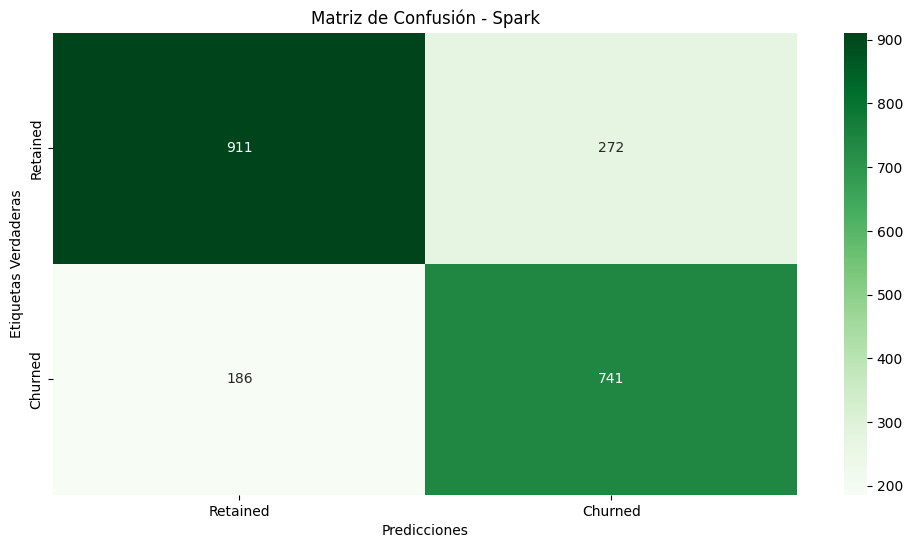

In [60]:
show_conf_matrix(predictions_dt)

CONCLUSIONES

### 4.1.3 AUC ROC y Precision-Recall

In [62]:
auc_metrics(predictions_dt)


        AUC ROC:  0.6976289414676271

        AUC Precision-Recall: 0.7019396473810666


CONCLUSIONES

### 4.1.4 Conclusiones finales

CONCLUSIONES

## 4.2 Random Forest

### 4.2.1 Entrenamiento y feature_importance

CONCLUSIONES

### 4.2.2 Matriz de confusión

CONCLUSIONES

### 4.2.3 AUC ROC y Precision-Recall

CONCLUSIONES

### 4.2.4 Conclusiones finales

Conclusiones

## 4.3 GBTClassifier

### 4.3.1 Entrenamiento y feature_importance

CONCLUSIONES

### 4.3.2 Matriz de confusión

CONCLUSIONES

### 4.3.3 AUC ROC y Precision-Recall

CONCLUSIONES

### 4.3.4 Conclusiones finales

CONCLUSIONES

## 4.4 Comparativa modelos

CONCLUSIONES

# 4.5 Fine Tuning